<a href="https://colab.research.google.com/github/david-adewoyin/UNet/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## U-Net Image Segmentation Implementation 
This notebook shows how to implement the [U-Net architecture](https://arxiv.org/abs/1505.04597) for image segmentation using Tensorflow. The model was trained and evaluated on the CARLA image segmentation dataset and after `40 EPOCHS ` the accuracy on the training set was recorded as `0.9603` and on the validation set it was `0.9487`.

<img src="https://user-images.githubusercontent.com/57121852/196273918-208c1a81-4387-4a84-a174-cd5b2100a4a9.png" alt='Unet architecture diagram' height='420px' width='520px'>

In [ ]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf
import tensorflow.keras as keras
from  tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

import matplotlib.pyplot as plt

In [2]:
## CONFIGURATION 
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 8

IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
## if you're running the code on google colab, 
## uncomment the following 3 lines out to fetch the images for training and comment the last two lines
#!git clone https://github.com/david-adewoyin/UNet.git
#image_dir = '/content/UNet/data/images/'
#masks_dir = '/content/UNet/data/masks/'

image_dir = "/data/images/"
masks_dir = "/data/masks/"

In [4]:
images_list = listdir(image_dir)
masks_list = listdir(masks_dir)

images_path =  [image_dir + i  for i in  images_list]
masks_path  = [masks_dir + i  for i in masks_list]

In [5]:
def load_images(image_path, mask_path, img_size = (256,256)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask,img_size, method = 'nearest')
  
  return img, mask

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((images_path,masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).cache()

In [7]:
# divide our dataset into training and test set
val_dataset = (dataset
               .take(100)
               .prefetch(buffer_size=tf.data.AUTOTUNE) )
train_dataset = (dataset
               .skip(100)
               .prefetch(buffer_size=tf.data.AUTOTUNE)) 
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

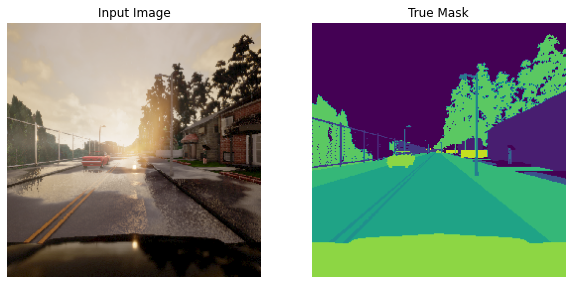

In [12]:
# plot images
def display(display_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask])
  

## Unet Model
The Unet Architecture consists of a contracting path (left side) and an expansive (right path).The contracting path follows the typical architecure of a regular convolutional network


In [13]:
class DoubleConv(keras.layers.Layer):

  """ (convolution => [BN] => Relu) *2 
  Each step in the contracting and expansive path have two 3x3 convolutional layer
  In the U-Nnet padding they used 0 padding but we use 1 padding so that we don't crop the final feature map
  """
  def __init__(self,filters):
    super(DoubleConv,self).__init__()

    # First 3x3 convolutional layer
    self.first = layers.Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = 'he_normal')
    self.batch1 = layers.BatchNormalization()
    self.act1 = layers.Activation('relu')

    # 2nd 3x3 convolutional layer
    self.second= layers.Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = 'he_normal')
    self.batch2 = layers.BatchNormalization()
    self.act2 = layers.Activation('relu')

  def call(self,inputs):
    # Apply the two convolutional layers
    x = self.first(inputs)
    x = self.batch1(x)
    x = self.act1(x)

    x = self.second(x)
    x = self.batch2(x)
    return self.act2(x)

class DownSampling(keras.layers.Layer):
  """ downsamples the feature map with a maxpool layer(2) followed by a double conv """

  def __init__(self,filters):
    super(DownSampling,self).__init__()
    # Max pooling Layer
    self.pool = layers.MaxPooling2D(2)
    self.conv = DoubleConv(filters)

  def call(self,inputs):
    x = self.pool(inputs)
    return self.conv(x)

class UpSampling(keras.layers.Layer):
  """Each Step in the expansive path up-samples the feature map with a 2x2 convolution follwed a double conv"""

  def __init__(self,filters):
    super(UpSampling,self).__init__()
    self.up = layers.Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding = 'same', kernel_initializer = 'he_normal')
    self.conv = DoubleConv(filters)
  
  def call(self,inputs,corresponding_map):
   upsamp = self.up(inputs)
 
   crop = layers.CenterCrop(upsamp.shape[1],upsamp.shape[2])(corresponding_map)
   x = layers.Concatenate()([upsamp,crop])
   return self.conv(x)

In [14]:
class UNet(keras.Model):

  def __init__(self, num_classes = 23):
      
    super(UNet,self).__init__()
    self.inc = DoubleConv(filters=64)
    self.down1 = DownSampling(filters=128)
    self.down2 = DownSampling(filters=256)
    self.down3 = DownSampling(filters=512)
    self.down4 = DownSampling(filters = 1024)

    self.up1 = UpSampling(filters = 1024)
    self.up2 = UpSampling(filters = 512)
    self.up3 = UpSampling(filters = 256)
    self.up4 = UpSampling(filters = 128)

    self.out = DoubleConv(filters=64)

    # final prediction classes
    self.outc = layers.Conv2D(num_classes, kernel_size = 1,padding='same')

  def call(self,inputs):
    #input =  layers.Input(shape =(256,256,3))(inputs) #self.first(inputs)
    skip1 = self.inc(inputs)
    skip2 = self.down1(skip1)
    skip3 = self.down2(skip2)
    skip4 = self.down3(skip3)

    x = self.down4(skip4)

    x = self.up1(x,skip1)
    x = self.up2(x,skip2)
    x = self.up3(x,skip3)
    x = self.up4(x,skip4)
    
    x = self.out(x)
    
    return self.outc(x)

In [17]:
model = UNet( num_classes = 23 )
model.compile(
     optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
  )

In [18]:
callbacks = [
    ReduceLROnPlateau(patience=3, verbose=1),
    EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('unet-model.h5', verbose=0, save_best_only=True,save_weights_only=True)
    ]

In [19]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      validation_steps = 8,
      callbacks = callbacks, 
    )

Epoch 1/40
25/25 [==============================] - 98s 2s/step - loss: 1.4537 - accuracy: 0.6747 - val_loss: 13497.5996 - val_accuracy: 0.1107 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 43s 2s/step - loss: 0.6723 - accuracy: 0.8447 - val_loss: 2.7547 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 43s 2s/step - loss: 0.5069 - accuracy: 0.8695 - val_loss: 3.3706 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 43s 2s/step - loss: 0.4145 - accuracy: 0.8878 - val_loss: 2.8709 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8999
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
25/25 [==============================] - 42s 2s/step - loss: 0.3521 - accuracy: 0.8999 - val_loss: 2.8197 - val_accuracy: 0.4651 - lr: 0.0010
Epoch 6/40
25/25 [==============================] - 43s 2s/step - loss:

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

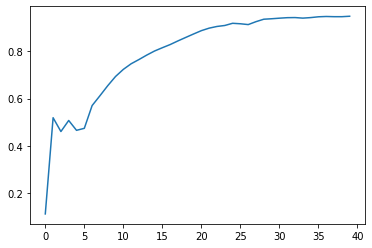

In [21]:
plt.plot(history.history["val_accuracy"])

In [22]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 332ms/step


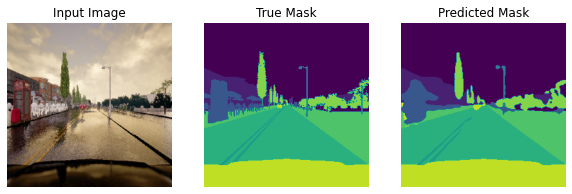

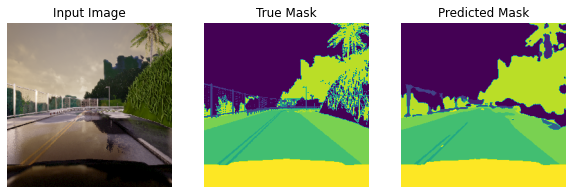

In [25]:
## displaying our result
show_predictions(val_dataset,num=2)